# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import numpy as np
from easydict import EasyDict
import yaml
from sklearn.model_selection import train_test_split
import os
from os import listdir
import matplotlib.pyplot as plt
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder  
import librosa
import librosa.display
import cv2
import zipfile
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import time
import copy
import IPython.display as ipd
import math
import tensorflow_datasets as tfds

# Loading dataset

In [ ]:
# ds = tfds.load('vctk', 
#                split='train', 
#                shuffle_files=True, 
#                data_dir='/content/drive/MyDrive/НИС_2022/accent_recognition')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip -d data/

In [ ]:
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data.is.ed.ac.uk_bits_hand_1028_3443_VCTK-IyXfMFBjd_cDYW_9GQ4AOewkjaM0aBWvguBMOZrdoIw.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/НИС_2022/accent_recognition/downloads/data2")
# zip_ref.close()

In [ ]:
!ls

speaker-info.txt  txt  update.txt  wav48_silence_trimmed


In [2]:
speaker_info_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/speaker-info.txt'
speakers_dict = {}
accent_dict = {}
speakers = []
labels = []
ban = ['Unknown', 'NewZealand', 'English', 'Welsh', 'NorthernIrish', 'Irish']
with open(speaker_info_path) as f:
    line = f.readline()
    while line:
        line = f.readline()
        try:
          accent = line.split()[3]
          speaker = line.split()[0]
          if accent in ban:
              continue
          if accent in speakers_dict:
              speakers_dict[accent] += 1
          else:
              speakers_dict[accent] = 1
              accent_dict[accent] = []
          accent_dict[accent].append(speaker)
          speakers.append(speaker)
          labels.append(accent)
        except:
          continue

In [3]:
speakers_dict

{'American': 22,
 'Australian': 2,
 'British': 1,
 'Canadian': 8,
 'Indian': 3,
 'Scottish': 19,
 'SouthAfrican': 4}

In [3]:
speakers_train = []
speakers_test = []
labels_train = []
labels_test = []
for key in accent_dict:
    labels_list = [key for _ in range(len(accent_dict[key]))]
    if key == 'British':
        speakers_train.extend(accent_dict[key])
        labels_train.extend(labels_list)
        speakers_test.extend(accent_dict[key])
        labels_test.extend(labels_list)
    else:
        speakers_train_cur, speakers_test_cur, labels_train_cur, labels_test_cur = train_test_split(
            accent_dict[key], labels_list, test_size=0.2, random_state=42)
        
        speakers_train.extend(speakers_train_cur)
        speakers_test.extend(speakers_test_cur)
        labels_train.extend(labels_train_cur)
        labels_test.extend(labels_test_cur)

In [4]:
train_audio_parts = []
test_audio_parts = []

speakers_train_paths = []
speakers_train_labels = []

speakers_test_paths = []
speakers_test_labels = []

In [6]:
# add accent archive data
accent_archive_labels = ['australia', 'uk', 'canada']
accent_archive_labels_map = {'australia': 'Australian', 
                             'uk' : 'British', 
                             'canada' : 'Canadian'}

accent_archive_path = '/content/drive/MyDrive/NIS_2022/accent_archive/data/audio/'
for accent_archive_label in accent_archive_labels:
    audio_path = accent_archive_path + accent_archive_label + '/'
    files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]
    label = accent_archive_labels_map[accent_archive_label]
    for file_name in files:
        try:
            waveform, sr = torchaudio.load(audio_path + file_name)
            spect_frames_num = waveform.shape[1] / sr * 100
            split_num = math.ceil(spect_frames_num / 256)
            for i in range(split_num):
                train_audio_parts.append(i)
                speakers_train_paths.append(audio_path + file_name)
                speakers_train_labels.append(label)
        except:
            continue

In [5]:
#process british
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/'

speaker = 's5'
label = 'British'
speaker_path = path + speaker + '/'
files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]

train_len = int(0.8 * len(files))
test_len = len(files) - train_len
for file_name in files[:train_len]:
    if 'mic2' in file_name:
        continue
    try:
        # wav, sr = librosa.load(speaker_path + file_name, sr=None)
        waveform, sr = torchaudio.load(speaker_path + file_name)
        spect_frames_num = waveform.shape[1] / sr * 100
        split_num = math.ceil(spect_frames_num / 256)
        for i in range(split_num):
            train_audio_parts.append(i)
            speakers_train_paths.append(speaker_path + file_name)
            speakers_train_labels.append(label)
    except:
        continue
            
for file_name in files[train_len:]:
    if 'mic2' in file_name:
        continue
    try:
        # wav, sr = librosa.load(speaker_path + file_name, sr=None)
        waveform, sr = torchaudio.load(speaker_path + file_name)
        spect_frames_num = waveform.shape[1] / sr * 100
        split_num = math.ceil(spect_frames_num / 256)
        for i in range(split_num):
            test_audio_parts.append(i)
            speakers_test_paths.append(speaker_path + file_name)
            speakers_test_labels.append(label)
    except:
        continue



In [7]:
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    
    if label == 'British':
      continue

    # if len(files) > 50:
    #     files = files[:50]
    for file_name in files:
        if 'mic2' in file_name:
            continue
        try:
            waveform, sr = torchaudio.load(speaker_path + file_name)
            spect_frames_num = waveform.shape[1] / sr * 100
            split_num = math.ceil(spect_frames_num / 256)
            for i in range(split_num):
                train_audio_parts.append(i)
                speakers_train_paths.append(speaker_path + file_name)
                speakers_train_labels.append(label)
        except:
            continue


In [6]:
for speaker, label in zip(speakers_test, labels_test):
    if label == 'British':
        continue
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    # if len(files) > 50:
    #     files = files[:50]
    for file_name in files:
        if 'mic2' in file_name:
            continue
        try:
            waveform, sr = torchaudio.load(speaker_path + file_name)
            spect_frames_num = waveform.shape[1] / sr * 100
            split_num = math.ceil(spect_frames_num / 256)
            for i in range(split_num):
                test_audio_parts.append(i)
                speakers_test_paths.append(speaker_path + file_name)
                speakers_test_labels.append(label)
        except:
            continue

In [8]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

In [9]:
le.classes_

array(['American', 'Australian', 'British', 'Canadian', 'Indian',
       'Scottish', 'SouthAfrican'], dtype='<U12')

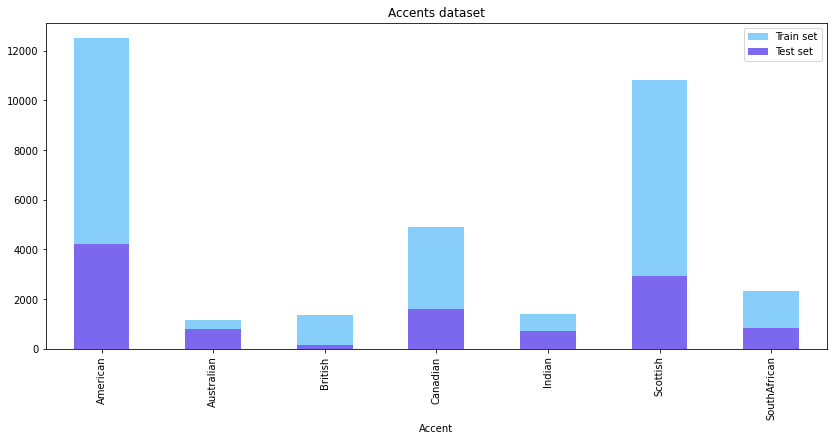

In [ ]:
unique_elements_train, counts_elements_train = np.unique(le.inverse_transform(speakers_train_labels), 
                                                         return_counts=True)

unique_elements_test, counts_elements_test = np.unique(le.inverse_transform(speakers_test_labels), 
                                                       return_counts=True)

df = pd.DataFrame({
    'Accent': unique_elements_train,
    'Train set': counts_elements_train,
    'Test set': counts_elements_test
})
  
ax = df.plot(x="Accent", y='Train set', kind="bar", figsize=(14, 6), color="lightskyblue")
df.plot(x="Accent", y='Test set', kind="bar", ax=ax, color="mediumslateblue")
plt.title('Accents dataset')
plt.show()

In [ ]:
le.inverse_transform(speakers_train_labels)

array(['English', 'English', 'English', ..., 'Canadian', 'Canadian',
       'Canadian'], dtype='<U8')

## Data sample

In [37]:
# scottish
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p323/p323_005_mic2.flac'

In [38]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:], rate=sample_rate)

In [ ]:
sound.shape

torch.Size([1, 305205])

In [ ]:
sample_rate

48000

In [ ]:
def get_spec(path, audio_part=0):
    waveform, sr = torchaudio.load(path)
    waveform = waveform - waveform.mean()
    fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                              window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

    target_length = 256
    start = audio_part * target_length
    end = start + target_length

    if end >= fbank.shape[0]:
        end = fbank.shape[0]

    fbank = fbank[start:end, :]
    n_frames = fbank.shape[0]
    p = target_length - n_frames

    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

  # fbank = torch.transpose(fbank, 0, 1)
  # fbank = fbank.unsqueeze(0)
  # fbank = torch.transpose(fbank, 0, 1)

  # fbank = fbank.unsqueeze(0)
  # timem = torchaudio.transforms.TimeMasking(time_mask_param=50)
  # fbank = timem(fbank)

    fbank = fbank.squeeze(0)
    fbank = torch.transpose(fbank, 0, 1)
    norm_mean = -0.06320914
    norm_std = 0.4981031
    fbank = (fbank - norm_mean) / (norm_std * 2)
    
    fbank = torch.reshape(fbank, (1, 128, 256))
    # fbank = fbank.expand(3, -1, -1)
    print(fbank.shape)
    plt.imshow(fbank[0].cpu().numpy())
    transform = transforms.ToPILImage()
    img = transform(fbank)
    return img

torch.Size([1, 128, 256])


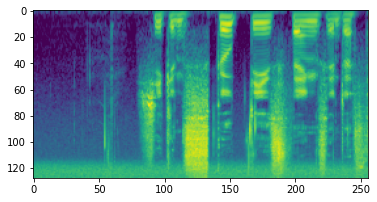

In [ ]:
img = get_spec(path, 0)
# plt.imshow(img)

torch.Size([1, 128, 256])


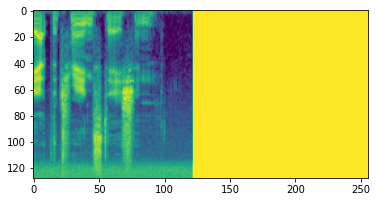

In [ ]:
img = get_spec(path, 2)

In [ ]:
# english
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/p225/p225_006_mic1.flac'

In [ ]:
sound, sample_rate = torchaudio.load(path)
ipd.Audio(data=sound[0,:],rate=sample_rate)

torch.Size([1, 128, 256])


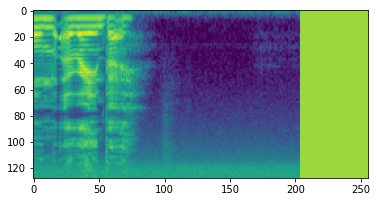

In [ ]:
img = get_spec(path, 2)
# plt.imshow(img)

In [ ]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    path = os.fspath(file_path)
    wav,sr = librosa.load(path,sr=sr)
    # if wav.shape[0]<5*sr:
    #     wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    # else:
    #     wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
                hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db


def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled



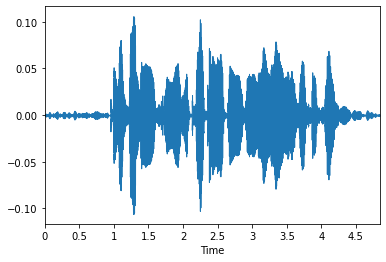

In [ ]:
y, sr = librosa.load(path)

whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr);

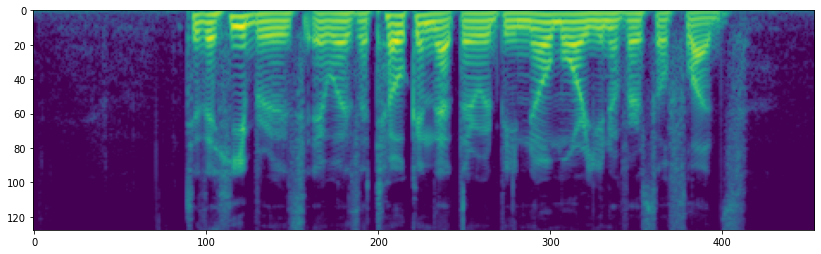

In [ ]:
melspectrogram = spec_to_image(get_melspectrogram_db(path))

plt.figure(figsize=(14, 8))
plt.imshow(melspectrogram)

## Melspectrograms saving

In [ ]:
test_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/validation/'
for speakers_test_path, speakers_test_label in zip(speakers_test_paths, 
                                                   le.inverse_transform(speakers_test_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_test_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = test_data_path+speakers_test_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_test_path))[0]+'.png')

In [ ]:
train_data_path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/train/'
for speakers_train_path, speakers_train_label in zip(speakers_train_paths, 
                                                   le.inverse_transform(speakers_train_labels)):
    try:
        melspectrogram = spec_to_image(get_melspectrogram_db(speakers_train_path))
    except:
        continue
    img = Image.fromarray(melspectrogram)

    save_path = train_data_path+speakers_train_label
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    img.save(save_path+'/'+os.path.splitext(os.path.basename(speakers_train_path))[0]+'.png')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
res = cv2.resize(melspectrogram, dsize=(128, 64), interpolation=cv2.INTER_CUBIC)

In [ ]:
melspectrogram.shape

(128, 370)

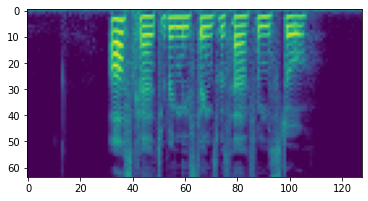

In [ ]:
plt.imshow(res)

In [ ]:
np.reshape(res, (1, 64, 128)).shape

(1, 64, 128)

## Format data

In [ ]:
# def spec_to_image(spec, eps=1e-6):
#     mean = spec.mean()
#     std = spec.std()
#     spec_norm = (spec - mean) / (std + eps)
#     spec_min, spec_max = spec_norm.min(), spec_norm.max()
#     spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
#     # spec_scaled = spec_scaled.astype(np.uint8)
#     return spec_scaled

# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, audio_paths, labels):
#         self.audio_paths = audio_paths
#         self.labels = labels
#         # self.is_valid = is_valid
#         # if self.is_valid == 1:
#         #     self.aug = # transfoms for validation images
#         # else:                  
#         #     self.aug = # transfoms for training images

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, index):
#         filename = self.audio_paths[index]
#         mel_specgram = spec_to_image(get_melspectrogram_db(filename))[np.newaxis,...]
#         res = cv2.resize(mel_specgram[0, :, :], dsize=(128, 64), interpolation=cv2.INTER_CUBIC)
#         return torch.tensor(np.reshape(res, (1, 64, 128)), dtype = torch.float), self.labels[index]

# train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
# test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels
        # self.is_valid = is_valid
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        fbank = self._wav2fbank(filename)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -4.71
        norm_std = 4.93
        fbank = (fbank - norm_mean) / (norm_std * 2)
        fbank = torch.reshape(fbank, (1, 128, 256))
        fbank = fbank.expand(3, -1, -1)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

torch.Size([1, 64, 128])


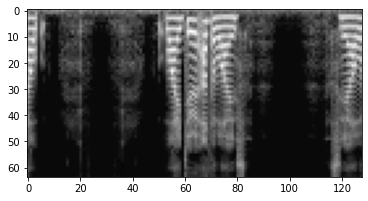

In [ ]:
def display_img(img,label):
    print(img.shape)
    plt.imshow(img[0, :, :], cmap='gray')

display_img(*train_dataset[4])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

# Train the CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def accuracy(outputs, labels):
    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
    _, preds = torch.max(y_pred_softmax, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class AccentClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(131072, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
model = AccentClassification()
model = model.to(device)

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.00001
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

Epoch [0], train_loss: 1.0098, val_loss: 1.2691, val_acc: 0.5218
Epoch [1], train_loss: 0.7526, val_loss: 1.4137, val_acc: 0.4755
Epoch [2], train_loss: 0.4948, val_loss: 1.4587, val_acc: 0.5043
Epoch [3], train_loss: 0.2993, val_loss: 1.8356, val_acc: 0.5418
Epoch [4], train_loss: 0.1894, val_loss: 1.9959, val_acc: 0.5348


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[3408,  376,  324,  110],
       [1071,  449,   30,    0],
       [ 863,   68, 3602, 1675],
       [ 284,   15, 2164,  565]])

In [ ]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.61      0.81      0.69      4218
           1       0.49      0.29      0.37      1550
           2       0.59      0.58      0.58      6208
           3       0.24      0.19      0.21      3028

    accuracy                           0.53     15004
   macro avg       0.48      0.47      0.46     15004
weighted avg       0.51      0.53      0.52     15004



In [ ]:
le.classes_

array(['American', 'Canadian', 'English', 'Scottish'], dtype='<U8')

# ResNet fine-tuning

## Data loading

In [ ]:
import torchvision.models as models

In [ ]:
# input_size = 224
batch_size = 32

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels, audio_parts, freq_mask=False, time_mask=False):
        self.audio_paths = audio_paths
        self.labels = labels
        self.audio_parts = audio_parts
        self.freq_mask = freq_mask
        self.time_mask = time_mask
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename, audio_part):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        start = audio_part * target_length
        end = start + target_length

        if end >= fbank.shape[0]:
            end = fbank.shape[0]

        fbank = fbank[start:end, :]
        n_frames = fbank.shape[0]
        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        audio_part = self.audio_parts[index]
        fbank = self._wav2fbank(filename, audio_part)
        # fbank = torch.transpose(fbank, 0, 1)
        # fbank = fbank.unsqueeze(0)
        if self.freq_mask:
            freqm = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
            fbank = freqm(fbank)
        if self.time_mask:
            fbank = fbank.unsqueeze(0)
            timem = torchaudio.transforms.TimeMasking(time_mask_param=50)
            fbank = timem(fbank)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -4.71
        norm_std = 4.93
        fbank = (fbank - norm_mean) / (norm_std * 2)
        
        fbank = torch.reshape(fbank, (1, 128, 256))
        fbank = fbank.expand(3, -1, -1)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset_no_aug = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts)
train_dataset_freq_mask = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts,
                                    freq_mask=True, time_mask=False)

train_dataset_time_mask = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts,
                                    freq_mask=False, time_mask=True)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_aug,
                                                train_dataset_freq_mask,
                                                train_dataset_time_mask])
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels, test_audio_parts)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers=4)

In [ ]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

In [ ]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'validation': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# data_dir = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/melspectograms/'
# image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
# dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
#                                                    batch_size=batch_size, 
#                                                    shuffle=True, 
#                                                    num_workers=4) for x in ['train', 'validation']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Train & Validate

In [ ]:
num_classes = 7
num_epochs = 6

In [ ]:
resnet18_pretrained = models.resnet18(pretrained=True)
resnet18_pretrained.fc = nn.Linear(512, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # _, preds = torch.max(outputs, 1)

                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
resnet18_pretrained = resnet18_pretrained.to(device)

# conv_weight = resnet18_pretrained.conv1[0].weight
# resnet18_pretrained.conv1[0].weight = torch.nn.Parameter(conv_weight.sum(dim=1), keepdim=True)

params_to_update = resnet18_pretrained.parameters()
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

In [ ]:
criterion = nn.CrossEntropyLoss()
# Train and evaluate
resnet18_pretrained, hist = train_model(resnet18_pretrained,
                                        dataloaders_dict,
                                        criterion, optimizer_ft, 
                                        num_epochs=num_epochs)

Epoch 0/5
----------
train Loss: 1.4108 Acc: 0.4687
validation Loss: 1.7611 Acc: 0.4253

Epoch 1/5
----------
train Loss: 1.0492 Acc: 0.6093
validation Loss: 1.6422 Acc: 0.4796

Epoch 2/5
----------
train Loss: 0.8865 Acc: 0.6678
validation Loss: 1.5771 Acc: 0.5110

Epoch 3/5
----------
train Loss: 0.7712 Acc: 0.7131
validation Loss: 1.5757 Acc: 0.5246

Epoch 4/5
----------
train Loss: 0.6796 Acc: 0.7483
validation Loss: 1.5785 Acc: 0.5331

Epoch 5/5
----------
train Loss: 0.6072 Acc: 0.7810
validation Loss: 1.5921 Acc: 0.5603

Training complete in 22m 30s
Best val Acc: 0.560272


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
resnet18_pretrained.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = resnet18_pretrained(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
print(classification_report(le.inverse_transform(y_labels_list), 
                            le.inverse_transform(y_pred_list)))

              precision    recall  f1-score   support

    American       0.47      0.90      0.62       357
  Australian       0.00      0.00      0.00        80
     British       0.75      0.98      0.85       155
    Canadian       0.14      0.06      0.08       148
      Indian       0.00      0.00      0.00        79
    Scottish       0.91      0.64      0.75       278
SouthAfrican       0.00      0.00      0.00        81

    accuracy                           0.56      1178
   macro avg       0.32      0.37      0.33      1178
weighted avg       0.47      0.56      0.49      1178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[322,   0,   1,  17,   0,   8,   9],
       [ 35,   0,   0,  28,   3,   1,  13],
       [  3,   0, 152,   0,   0,   0,   0],
       [126,   0,   2,   9,   0,   0,  11],
       [ 53,   0,  18,   1,   0,   7,   0],
       [ 64,   0,  29,   8,   0, 177,   0],
       [ 78,   0,   1,   1,   0,   1,   0]])

In [ ]:
le.classes_

array(['American', 'Canadian', 'English', 'Scottish'], dtype='<U8')

# Transformer fine-tuning

https://github.com/YuanGongND/ast

## Data loading

In [ ]:
speakers_train = []
speakers_test = []
labels_train = []
labels_test = []

for key in accent_dict:
    labels_list = [key for _ in range(len(accent_dict[key]))]
    speakers_train_cur, speakers_test_cur, labels_train_cur, labels_test_cur = train_test_split(
        accent_dict[key], labels_list, test_size=0.2, random_state=42)
    
    speakers_train.extend(speakers_train_cur)
    speakers_test.extend(speakers_test_cur)
    labels_train.extend(labels_train_cur)
    labels_test.extend(labels_test_cur)

In [ ]:
path = '/content/drive/MyDrive/NIS_2022/accent_recognition/data/wav48_silence_trimmed/'
speakers_train_paths = []
speakers_train_labels = []
count = 0
for speaker, label in zip(speakers_train, labels_train):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 900:
        files = files[:900]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_train_paths.append(speaker_path + file_name)
            speakers_train_labels.append(label)
        except:
            continue


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
speakers_test_paths = []
speakers_test_labels = []
count = 0
for speaker, label in zip(speakers_test, labels_test):
    speaker_path = path + speaker + '/'
    files = [f for f in listdir(speaker_path) if isfile(join(speaker_path, f))]
    if len(files) > 900:
      files = files[:900]
    for file_name in files:
        # if 'mic2' in file_name:
        #     continue
        try:
            wav, sr = librosa.load(speaker_path + file_name, sr=None)
            speakers_test_paths.append(speaker_path + file_name)
            speakers_test_labels.append(label)
        except:
            continue

In [ ]:
le = LabelEncoder()
speakers_train_labels = le.fit_transform(speakers_train_labels)
speakers_test_labels = le.transform(speakers_test_labels)

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels, audio_parts, freq_mask=False, time_mask=False):
        self.audio_paths = audio_paths
        self.labels = labels
        self.audio_parts = audio_parts
        self.freq_mask = freq_mask
        self.time_mask = time_mask
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename, audio_part):
        waveform, sr = torchaudio.load(filename)
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        start = audio_part * target_length
        end = start + target_length

        if end >= fbank.shape[0]:
            end = fbank.shape[0]

        fbank = fbank[start:end, :]
        n_frames = fbank.shape[0]
        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        audio_part = self.audio_parts[index]
        fbank = self._wav2fbank(filename, audio_part)
        # fbank = torch.transpose(fbank, 0, 1)
        # fbank = fbank.unsqueeze(0)
        if self.freq_mask:
            freqm = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
            fbank = freqm(fbank)
        if self.time_mask:
            fbank = fbank.unsqueeze(0)
            timem = torchaudio.transforms.TimeMasking(time_mask_param=50)
            fbank = timem(fbank)

        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
         
        norm_mean = -5.333907
        norm_std = 4.913365
        fbank = (fbank - norm_mean) / (norm_std * 2)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset_no_aug = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts)
train_dataset_freq_mask = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts,
                                    freq_mask=True, time_mask=False)

train_dataset_time_mask = MyDataset(speakers_train_paths, speakers_train_labels, train_audio_parts,
                                    freq_mask=False, time_mask=True)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_aug,
                                                train_dataset_freq_mask,
                                                train_dataset_time_mask])

test_dataset = MyDataset(speakers_test_paths, speakers_test_labels, test_audio_parts)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers=4)

In [12]:
train_loader.dataset[26][0].shape

torch.Size([128, 256])

In [13]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

In [16]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd951949910>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7fd951949150>}

In [ ]:
# mean=[]
# std=[]
# for i, (audio_input, labels) in enumerate(train_loader):
#     cur_mean = torch.mean(audio_input)
#     cur_std = torch.std(audio_input)
#     mean.append(cur_mean)
#     std.append(cur_std)
#     print(cur_mean, cur_std)
# print(np.mean(mean), np.mean(std))

tensor(-5.1165) tensor(5.1194)
tensor(-5.2577) tensor(4.8437)
tensor(-5.9316) tensor(4.8216)
tensor(-5.3917) tensor(4.9598)
tensor(-5.7801) tensor(4.6888)
tensor(-5.0774) tensor(4.9125)
tensor(-5.4242) tensor(5.0391)
tensor(-5.7602) tensor(4.7473)
tensor(-5.3374) tensor(4.9748)
tensor(-5.3759) tensor(4.8105)
tensor(-4.9859) tensor(4.8844)
tensor(-5.8402) tensor(4.6433)
tensor(-5.5221) tensor(5.0317)
tensor(-4.8025) tensor(4.8254)
tensor(-5.1017) tensor(4.8707)
tensor(-5.6014) tensor(4.8612)
tensor(-5.7140) tensor(4.8773)
tensor(-5.5782) tensor(5.0229)
tensor(-5.3806) tensor(5.1029)
tensor(-4.6167) tensor(4.8520)
tensor(-4.8516) tensor(4.9785)
tensor(-5.6524) tensor(4.8701)
tensor(-4.6800) tensor(5.0606)
tensor(-4.7108) tensor(4.7418)
tensor(-4.9100) tensor(4.9538)
tensor(-4.7952) tensor(4.9883)
tensor(-5.0326) tensor(4.8962)
tensor(-5.1935) tensor(5.0094)
tensor(-6.0218) tensor(4.7722)
tensor(-5.3801) tensor(4.8046)
tensor(-5.9356) tensor(4.7995)
tensor(-4.7231) tensor(5.1076)
tensor(-

## Model creating

In [14]:
!pip install timm==0.4.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.1 MB/s 


In [15]:
from torch.cuda.amp import autocast
import os
import timm
from timm.models.layers import to_2tuple,trunc_normal_

In [16]:
# override the timm package to relax the input shape constraint.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class ASTModel(nn.Module):
    """
    The AST model.
    :param label_dim: the label dimension, i.e., the number of total classes, it is 527 for AudioSet, 50 for ESC-50, and 35 for speechcommands v2-35
    :param fstride: the stride of patch spliting on the frequency dimension, for 16*16 patchs, fstride=16 means no overlap, fstride=10 means overlap of 6
    :param tstride: the stride of patch spliting on the time dimension, for 16*16 patchs, tstride=16 means no overlap, tstride=10 means overlap of 6
    :param input_fdim: the number of frequency bins of the input spectrogram
    :param input_tdim: the number of time frames of the input spectrogram
    :param imagenet_pretrain: if use ImageNet pretrained model
    :param audioset_pretrain: if use full AudioSet and ImageNet pretrained model
    :param model_size: the model size of AST, should be in [tiny224, small224, base224, base384], base224 and base 384 are same model, but are trained differently during ImageNet pretraining.
    """
    def __init__(self, label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, imagenet_pretrain=True, audioset_pretrain=False, model_size='base384', verbose=True):

        super(ASTModel, self).__init__()
        # assert timm.__version__ == '0.4.5', 'Please use timm == 0.4.5, the code might not be compatible with newer versions.'

        if verbose == True:
            print('---------------AST Model Summary---------------')
            print('ImageNet pretraining: {:s}, AudioSet pretraining: {:s}'.format(str(imagenet_pretrain),str(audioset_pretrain)))
        # override timm input shape restriction
        timm.models.vision_transformer.PatchEmbed = PatchEmbed

        # if AudioSet pretraining is not used (but ImageNet pretraining may still apply)
        if audioset_pretrain == False:
            if model_size == 'tiny224':
                self.v = timm.create_model('vit_deit_tiny_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'small224':
                self.v = timm.create_model('vit_deit_small_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base224':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_224', pretrained=imagenet_pretrain)
            elif model_size == 'base384':
                self.v = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=imagenet_pretrain)
            else:
                raise Exception('Model size must be one of tiny224, small224, base224, base384.')
            self.original_num_patches = self.v.patch_embed.num_patches
            self.oringal_hw = int(self.original_num_patches ** 0.5)
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            # automatcially get the intermediate shape
            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            # the linear projection layer
            new_proj = torch.nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
            if imagenet_pretrain == True:
                new_proj.weight = torch.nn.Parameter(torch.sum(self.v.patch_embed.proj.weight, dim=1).unsqueeze(1))
                new_proj.bias = self.v.patch_embed.proj.bias
            self.v.patch_embed.proj = new_proj

            # the positional embedding
            if imagenet_pretrain == True:
                # get the positional embedding from deit model, skip the first two tokens (cls token and distillation token), reshape it to original 2D shape (24*24).
                new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, self.original_num_patches, self.original_embedding_dim).transpose(1, 2).reshape(1, self.original_embedding_dim, self.oringal_hw, self.oringal_hw)
                # cut (from middle) or interpolate the second dimension of the positional embedding
                if t_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, :, int(self.oringal_hw / 2) - int(t_dim / 2): int(self.oringal_hw / 2) - int(t_dim / 2) + t_dim]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(self.oringal_hw, t_dim), mode='bilinear')
                # cut (from middle) or interpolate the first dimension of the positional embedding
                if f_dim <= self.oringal_hw:
                    new_pos_embed = new_pos_embed[:, :, int(self.oringal_hw / 2) - int(f_dim / 2): int(self.oringal_hw / 2) - int(f_dim / 2) + f_dim, :]
                else:
                    new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(f_dim, t_dim), mode='bilinear')
                # flatten the positional embedding
                new_pos_embed = new_pos_embed.reshape(1, self.original_embedding_dim, num_patches).transpose(1,2)
                # concatenate the above positional embedding with the cls token and distillation token of the deit model.
                self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))
            else:
                # if not use imagenet pretrained model, just randomly initialize a learnable positional embedding
                # TODO can use sinusoidal positional embedding instead
                new_pos_embed = nn.Parameter(torch.zeros(1, self.v.patch_embed.num_patches + 2, self.original_embedding_dim))
                self.v.pos_embed = new_pos_embed
                trunc_normal_(self.v.pos_embed, std=.02)

        # now load a model that is pretrained on both ImageNet and AudioSet
        elif audioset_pretrain == True:
            if audioset_pretrain == True and imagenet_pretrain == False:
                raise ValueError('currently model pretrained on only audioset is not supported, please set imagenet_pretrain = True to use audioset pretrained model.')
            if model_size != 'base384':
                raise ValueError('currently only has base384 AudioSet pretrained model.')
            # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # if os.path.exists('../../pretrained_models/audioset_10_10_0.4593.pth') == False:
                # this model performs 0.4593 mAP on the audioset eval set
            # audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
            # wget.download(audioset_mdl_url, out='../../pretrained_models/audioset_10_10_0.4593.pth')
            
            sd = torch.load('/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4593.pth')#, map_location=device)
            audio_model = ASTModel(label_dim=527, fstride=10, tstride=10, input_fdim=128, input_tdim=1024, 
                                   imagenet_pretrain=False, audioset_pretrain=False, model_size='base384', verbose=False)
            audio_model = torch.nn.DataParallel(audio_model)
            audio_model.load_state_dict(sd, strict=False)
            self.v = audio_model.module.v
            self.original_embedding_dim = self.v.pos_embed.shape[2]
            self.mlp_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim), nn.Linear(self.original_embedding_dim, label_dim))

            f_dim, t_dim = self.get_shape(fstride, tstride, input_fdim, input_tdim)
            num_patches = f_dim * t_dim
            self.v.patch_embed.num_patches = num_patches
            if verbose == True:
                print('frequncey stride={:d}, time stride={:d}'.format(fstride, tstride))
                print('number of patches={:d}'.format(num_patches))

            new_pos_embed = self.v.pos_embed[:, 2:, :].detach().reshape(1, 1212, 768).transpose(1, 2).reshape(1, 768, 12, 101)
            # if the input sequence length is larger than the original audioset (10s), then cut the positional embedding
            if t_dim < 101:
                new_pos_embed = new_pos_embed[:, :, :, 50 - int(t_dim/2): 50 - int(t_dim/2) + t_dim]
            # otherwise interpolate
            else:
                new_pos_embed = torch.nn.functional.interpolate(new_pos_embed, size=(12, t_dim), mode='bilinear')
            new_pos_embed = new_pos_embed.reshape(1, 768, num_patches).transpose(1, 2)
            self.v.pos_embed = nn.Parameter(torch.cat([self.v.pos_embed[:, :2, :].detach(), new_pos_embed], dim=1))

    def get_shape(self, fstride, tstride, input_fdim=128, input_tdim=1024):
        test_input = torch.randn(1, 1, input_fdim, input_tdim)
        test_proj = nn.Conv2d(1, self.original_embedding_dim, kernel_size=(16, 16), stride=(fstride, tstride))
        test_out = test_proj(test_input)
        f_dim = test_out.shape[2]
        t_dim = test_out.shape[3]
        return f_dim, t_dim

    @autocast()
    def forward(self, x):
        """
        :param x: the input spectrogram, expected shape: (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        :return: prediction
        """
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        for blk in self.v.blocks:
            x = blk(x)
        x = self.v.norm(x)
        x = (x[:, 0] + x[:, 1]) / 2

        x = self.mlp_head(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4593.pth'
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
input_tdim = 256

audio_model = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                       input_tdim=input_tdim, label_dim=7)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300


In [22]:
audio_model = audio_model.to(device)

## Train & Validate

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # try:
                #     inputs = inputs.reshape((10, 128, 128))
                # except:
                #     continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    
                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    
                    
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts, strict=False)
    return model, val_acc_history

In [24]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 1e-6, weight_decay=5e-7, betas=(0.95, 0.999))

In [25]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

In [26]:
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                loss_fn, optimizer, 
                                num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.8101 Acc: 0.7070
validation Loss: 1.4503 Acc: 0.5947

Epoch 1/4
----------
train Loss: 0.3874 Acc: 0.8575
validation Loss: 1.7210 Acc: 0.6155

Epoch 2/4
----------
train Loss: 0.2798 Acc: 0.8966
validation Loss: 1.8441 Acc: 0.6299

Epoch 3/4
----------
train Loss: 0.2274 Acc: 0.9165
validation Loss: 2.0067 Acc: 0.6331

Epoch 4/4
----------
train Loss: 0.1919 Acc: 0.9300
validation Loss: 2.0911 Acc: 0.6142

Training complete in 239m 48s
Best val Acc: 0.633061


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
print(classification_report(le.inverse_transform(y_labels_list), 
                            le.inverse_transform(y_pred_list)))

In [29]:
confusion_matrix(y_labels_list, y_pred_list)

array([[3946,    3,    0,  176,    6,   54,   44],
       [ 174,   24,    0,  501,   66,    4,   18],
       [   1,    0,  149,    0,    0,    5,    0],
       [1252,    1,    0,  286,    0,    7,   54],
       [  28,    0,  576,   15,   14,   80,    0],
       [ 142,    0,   56,    0,   15, 2706,    0],
       [ 647,    0,    3,  184,    0,   19,    2]])

In [30]:
le.classes_

array(['American', 'Australian', 'British', 'Canadian', 'Indian',
       'Scottish', 'SouthAfrican'], dtype='<U12')

In [31]:
%cd '/content/drive/MyDrive/NIS_2022/speech_recognition_models'

/content/drive/MyDrive/NIS_2022/speech_recognition_models


In [32]:
# !touch accent_classification_v7.pth

In [33]:
torch.save(audio_model.state_dict(), '/content/drive/MyDrive/NIS_2022/speech_recognition_models/accent_classification_7_classes_aug.pth')

In [20]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/speech_recognition_models/accent_classification_7_classes_aug.pth'
fstride, tstride = 10, 10
input_tdim = 256

audio_model_test = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                            input_tdim=input_tdim, label_dim=7)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300


In [21]:
sd = torch.load(pretrained_mdl_path)#, map_location=device)
audio_model_test.load_state_dict(sd, strict=False)

<All keys matched successfully>

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_model_test = audio_model_test.to(device)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model_test.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model_test(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])
        # for i_pred, pred, true_label in zip(range(batch_size), y_pred_tags.cpu().numpy(), labels.cpu().numpy()):
        #     if pred == true_label:
        #         pred_dict[true_label].append(test_audio_paths[i*batch_size + i_pred])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [25]:
print(classification_report(le.inverse_transform(y_labels_list), 
                            le.inverse_transform(y_pred_list)))

              precision    recall  f1-score   support

    American       0.64      0.93      0.76      4229
  Australian       0.86      0.03      0.06       787
     British       0.19      0.96      0.32       155
    Canadian       0.25      0.18      0.21      1600
      Indian       0.14      0.02      0.03       713
    Scottish       0.94      0.93      0.93      2919
SouthAfrican       0.02      0.00      0.00       855

    accuracy                           0.63     11258
   macro avg       0.43      0.44      0.33     11258
weighted avg       0.59      0.63      0.57     11258



In [26]:
confusion_matrix(y_labels_list, y_pred_list)

array([[3946,    3,    0,  176,    6,   54,   44],
       [ 174,   24,    0,  501,   66,    4,   18],
       [   1,    0,  149,    0,    0,    5,    0],
       [1252,    1,    0,  286,    0,    7,   54],
       [  28,    0,  576,   15,   14,   80,    0],
       [ 142,    0,   56,    0,   15, 2706,    0],
       [ 647,    0,    3,  184,    0,   19,    2]])

# Transformer fine-tuning (audio split)

## Data loading

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, audio_paths, labels, audio_part=None, is_valid=False, transforms=False):
        self.audio_paths = audio_paths
        self.labels = labels
        self.audio_part = audio_part
        self.is_valid = is_valid
        self.transforms = transforms
        # if self.is_valid == 1:
        #     self.aug = # transfoms for validation images
        # else:                  
        #     self.aug = # transfoms for training images

    def _wav2fbank(self, filename, audio_part=None):
        waveform, sr = torchaudio.load(filename)
        # if audio_part == 0:
        #     num_frames = waveform.shape[1] // 2
        #     waveform = waveform[:, :num_frames]
        # if audio_part == 1:
        #     num_frames = waveform.shape[1] // 2
        #     waveform = waveform[:, num_frames:]
        waveform = waveform - waveform.mean()
        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 256
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]
        return fbank
            

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        filename = self.audio_paths[index]
        label_indices = self.labels[index]
        if self.audio_part:
            audio_part = self.audio_part[index]
            fbank = self._wav2fbank(filename, audio_part)
        else:
            fbank = self._wav2fbank(filename, None)
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)
        norm_mean = -4.71
        norm_std = 4.93
        fbank = (fbank - norm_mean) / (norm_std * 2)
        # label_indices = torch.FloatTensor(label_indices)
        return fbank, label_indices

train_dataset = MyDataset(speakers_train_paths, speakers_train_labels, speakers_train_audio_path)
test_dataset = MyDataset(speakers_test_paths, speakers_test_labels)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True, num_workers=4)

In [ ]:
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['validation'] = test_loader

## Model creating

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
pretrained_mdl_path = '/content/drive/MyDrive/NIS_2022/accent_archive/audioset_10_10_0.4593.pth'
fstride, tstride = int(pretrained_mdl_path.split('/')[-1].split('_')[1]), int(pretrained_mdl_path.split('/')[-1].split('_')[2].split('.')[0])
input_tdim = 256

audio_model = ASTModel(imagenet_pretrain=True, audioset_pretrain=True,
                       input_tdim=input_tdim, label_dim=4)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=300


In [ ]:
audio_model = audio_model.to(device)

## Train & Validate

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, 
                num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global_step = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # try:
                #     inputs = inputs.reshape((10, 128, 128))
                # except:
                #     continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                # if global_step <= 300 and global_step % 20 == 0:
                #     warm_lr = (global_step / 300) * lr
                #     for param_group in optimizer.param_groups:
                #         param_group['lr'] = warm_lr
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    
                    y_pred_softmax = torch.log_softmax(outputs, dim = 1)
                    _, preds = torch.max(y_pred_softmax, dim = 1)    
                    
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                global_step += 1

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'validation':
                val_acc_history.append(epoch_acc)

        print()
    # scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts, strict=False)
    return model, val_acc_history

In [ ]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 1e-6, weight_decay=5e-7, betas=(0.95, 0.999))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

In [ ]:
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [0, 1, 2, 3, 4], gamma=0.5)

In [ ]:
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                loss_fn, optimizer, 
                                # scheduler,
                                # lr=1e-6,
                                num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 0.5403 Acc: 0.7691
validation Loss: 1.3081 Acc: 0.5575

Epoch 1/4
----------
train Loss: 0.2149 Acc: 0.9166
validation Loss: 1.7625 Acc: 0.5455

Epoch 2/4
----------
train Loss: 0.1302 Acc: 0.9504
validation Loss: 1.9502 Acc: 0.5638

Epoch 3/4
----------
train Loss: 0.0868 Acc: 0.9679
validation Loss: 2.4108 Acc: 0.5866

Epoch 4/4
----------
train Loss: 0.0594 Acc: 0.9778
validation Loss: 2.5024 Acc: 0.5822

Training complete in 352m 29s
Best val Acc: 0.586577


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      4218
           1       0.39      0.20      0.26      1550
           2       0.62      0.81      0.70      6208
           3       0.10      0.04      0.06      3028

    accuracy                           0.59     15004
   macro avg       0.45      0.46      0.44     15004
weighted avg       0.52      0.59      0.54     15004



In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[3341,  468,  245,  164],
       [1234,  311,    5,    0],
       [  76,   24, 5013, 1095],
       [   4,    3, 2885,  136]])

In [ ]:
%cd '/content/drive/MyDrive/NIS_2022/speech_recognition_models'
!touch accent_classification_v4.pth
torch.save(audio_model.state_dict(), '/content/drive/MyDrive/NIS_2022/speech_recognition_models/accent_classification_v4.pth')

/content/drive/MyDrive/NIS_2022/speech_recognition_models


In [ ]:
!touch accent_classification_v4.pth

In [ ]:
torch.save(audio_model.state_dict(), '/content/drive/MyDrive/NIS_2022/speech_recognition_models/accent_classification_v4.pth')

# AST training

In [ ]:
input_tdim = 256

audio_model = ASTModel(imagenet_pretrain=False, audioset_pretrain=False,
                       input_tdim=input_tdim, label_dim=4)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=300


In [ ]:
audio_model = audio_model.to(device)

In [ ]:
params_to_update = [p for p in audio_model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params_to_update, 0.00001, weight_decay=5e-7, betas=(0.95, 0.999))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

In [ ]:
audio_model, hist = train_model(audio_model,
                                dataloaders_dict,
                                loss_fn, optimizer, 
                                num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.9216 Acc: 0.5883
validation Loss: 1.5928 Acc: 0.4066

Epoch 1/9
----------
train Loss: 0.5744 Acc: 0.7576
validation Loss: 2.2171 Acc: 0.4286

Epoch 2/9
----------
train Loss: 0.3622 Acc: 0.8566
validation Loss: 2.0562 Acc: 0.4399

Epoch 3/9
----------
train Loss: 0.2276 Acc: 0.9152
validation Loss: 2.3219 Acc: 0.4907

Epoch 4/9
----------
train Loss: 0.1639 Acc: 0.9394
validation Loss: 2.8993 Acc: 0.4469

Epoch 5/9
----------
train Loss: 0.1188 Acc: 0.9567
validation Loss: 2.8322 Acc: 0.4591

Epoch 6/9
----------
train Loss: 0.0906 Acc: 0.9673
validation Loss: 2.8049 Acc: 0.4701

Epoch 7/9
----------
train Loss: 0.0703 Acc: 0.9746
validation Loss: 3.1167 Acc: 0.4849

Epoch 8/9
----------
train Loss: 0.0596 Acc: 0.9789
validation Loss: 2.9456 Acc: 0.4713

Epoch 9/9
----------
train Loss: 0.0422 Acc: 0.9852
validation Loss: 3.5189 Acc: 0.4495

Training complete in 159m 27s
Best val Acc: 0.490669


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain

y_pred_list = []
y_labels_list = []
audio_model.eval()
with torch.no_grad():
    for batch in dataloaders_dict['validation']:
        images, labels = batch
        y_labels_list.append(labels.numpy())
        images, _ = images.cuda(), labels.cuda()
        y_test_pred = audio_model(images)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
        y_pred_list.append([x for x in y_pred_tags.cpu().numpy()])

y_pred_list = list(chain.from_iterable(y_pred_list))
y_labels_list = list(chain.from_iterable(y_labels_list))

In [ ]:
print(classification_report(y_labels_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.54      0.64      0.58      4218
           1       0.46      0.44      0.45      1550
           2       0.61      0.57      0.59      6208
           3       0.17      0.15      0.16      3028

    accuracy                           0.49     15004
   macro avg       0.44      0.45      0.45     15004
weighted avg       0.48      0.49      0.49     15004



In [ ]:
confusion_matrix(y_labels_list, y_pred_list)

array([[2691,  694,  345,  488],
       [ 805,  689,   55,    1],
       [ 820,  103, 3533, 1752],
       [ 697,    3, 1879,  449]])